In [1]:
import numpy as np 
import matplotlib.pyplot as plt

from DSA import DSA, GeneralizedDSA, InputDSA
from DSA import DMD, DMDc, SubspaceDMDc, ControllabilitySimilarityTransformDist
from DSA import DMDConfig, DMDcConfig, SubspaceDMDcConfig
from DSA import SimilarityTransformDistConfig, ControllabilitySimilarityTransformDistConfig
from pydmd import DMD as pDMD
import DSA.pykoopman as pk
%load_ext autoreload
%autoreload 2

/orcd/data/fiete/001/om2/ostrow/dmrsa/DSApublic/DSA/DSA/pykoopman/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution


In [2]:
%pdb

Automatic pdb calling has been turned ON


In [3]:
d1 = np.random.random(size=(20,5))
u1 = np.random.random(size=(20,2))

# n_trials, n_timepoints, n_features
d2 = np.random.random(size=(3,20,5))
u2 = np.random.random(size=(3,20,2))

d3 = [np.random.random(size=(i,20,5)) for i in range(1,10)]
u3 = [np.random.random(size=(i,20,2)) for i in range(1,10)]

d4 = [np.random.random(size=(i+5,5)) for i in range(1,10)]
u4 = [np.random.random(size=(i+5,2)) for i in range(1,10)]

d5 = d4 + d3
u5 = u4 + u3

len(d5), len(d4)

(18, 9)

In [4]:

# dmdc = DMDc(d5,u5,n_delays=2,rank_input=10,rank_output=10)
# dmdc.fit()
# print(dmdc.A_v.shape)
# print(dmdc.B_v.shape)

# subdmdc = SubspaceDMDc(d3,u3,n_delays=3,rank=5,backend='n4sid')
# subdmdc.fit()
# print(subdmdc.A_v.shape)
# print(subdmdc.B_v.shape)

# Testing the case where n_delays >= trial_length / 2 in subspace dmdc
# prob_15 = 0.8
# prob_30 = 1 - prob_15
# n_arrays = 10

# # Generate the list
# d2 = [np.random.random(size=(np.random.choice([15, 30], p=[prob_15, prob_30]), 5)) 
#       for _ in range(n_arrays)]
# u2 = [np.random.random(size=(d.shape[0], 2)) 
#       for d in d2]  # match the first dimension from d2

# subdmdc = SubspaceDMDc(d2,u2,n_delays=6,rank=5,backend='n4sid')
# subdmdc.fit()
# print(subdmdc.A_v.shape)
# print(subdmdc.B_v.shape)


# passing list of 3D arrayss
subdmdc = SubspaceDMDc(d1,u1,n_delays=2,rank=10,backend='custom')
subdmdc.fit()
print(subdmdc.A_v.shape)
print(subdmdc.B_v.shape)


(10, 10)
(10, 2)


In [23]:
# check predictions for all cases

def make_stable_A(n, rho=0.9, rng=None):
    rng = np.random.default_rng(rng)
    M = rng.standard_normal((n, n))
    # Make it diagonally dominant-ish and scale spectral radius
    A = M / np.max(np.abs(np.linalg.eigvals(M))) * rho
    return A

def simulate_system(A, B, C, U, x0=None,rng=None,obs_noise=0.0,process_noise=0.0,
    nonlinear_eps=0.0,nonlinear_func= lambda x: np.tanh(x),nonlinear_eps_input=0.0,autonomous=False):
    n, m = B.shape
    p_out = C.shape[0]
    N = U.shape[1]
    X = np.zeros((n, N+1))
    C_full = np.eye(A.shape[0])
    C_full[np.where(C == 1)[1],np.where(C == 1)[1]] = 0.0

    if x0 is not None:
        X[:, 0] = x0
    else:
        X[:, 0] = np.random.default_rng(rng).standard_normal((n,))
    Y = np.zeros((p_out, N))
    for t in range(N):
        X[:, t+1] = A @ (X[:, t]) + nonlinear_eps * C_full @ nonlinear_func(A @ X[:, t]) + \
            B @ ((1-nonlinear_eps_input) * U[:, t] + nonlinear_eps_input * nonlinear_func(U[:, t])) + \
                np.random.normal(0, process_noise, (n,))
        Y[:, t] = C @ X[:, t] + np.random.normal(0, obs_noise, (p_out,))
    return X[:, 1:], Y  # states aligned with Y

def smooth_input(m, N, alpha=0.9, rng=None):
    rng = np.random.default_rng(rng)
    w = rng.standard_normal((m, N))
    U = np.zeros_like(w)
    for t in range(N):
        U[:, t] = alpha*(U[:, t-1] if t>0 else 0) + (1-alpha)*w[:, t]
    return U


latent_dim = 10
input_dim = 2
g1 = 0.5
seed1 = 123
seq_length = 500
input_alpha = 0.001
nonlinear_eps = 0.0
nonlinear_eps_input = 0.0
observed_dim = 9
idx_obs = np.arange(observed_dim)
A = make_stable_A(latent_dim)
B = np.random.default_rng(seed1).standard_normal((latent_dim, input_dim)) * g1
C = np.zeros((observed_dim, latent_dim))
C[np.arange(observed_dim), idx_obs] = 1.0
U = smooth_input(input_dim, seq_length, alpha=input_alpha, rng=seed1) 

X, Y = simulate_system(A, B, C, U, nonlinear_eps=nonlinear_eps)

X = X.T
Y = Y.T
U = U.T




print(X.shape)
print(Y.shape)

(500, 10)
(500, 9)


[ 0.8973288 +0.06928948j  0.8973288 -0.06928948j  0.51192657+0.j
  0.31817322+0.46791128j  0.31817322-0.46791128j -0.61083921+0.53853946j
 -0.61083921-0.53853946j -0.80198335+0.j         -0.14361156+0.j
 -0.33773263+0.j        ]
(500, 9) (500, 2)
[ 0.8973288 +0.06928948j  0.8973288 -0.06928948j  0.31817322+0.46791128j
  0.31817322-0.46791128j  0.51192656+0.j         -0.61083921+0.53853946j
 -0.61083921-0.53853946j -0.14361156+0.j         -0.33773262+0.j
 -0.80198335+0.j        ]


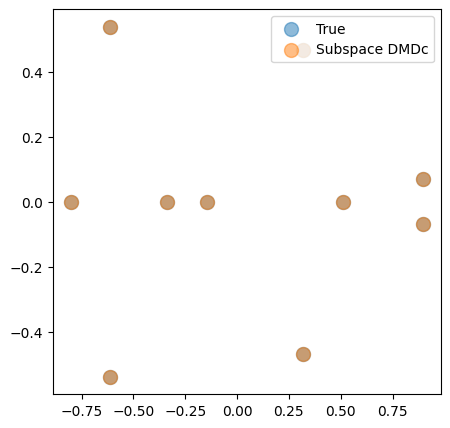

In [6]:
# Check that subspace dmdc works with (n_timepoints, n_features) data
print(np.linalg.eigvals(A))
print(Y.shape, U.shape)
subdmdc = SubspaceDMDc(Y,U,n_delays=10,rank=10,backend='n4sid')
subdmdc.fit()
print(np.linalg.eigvals(subdmdc.A_v))

# plot the two sets of eigenvalues as scatter plots
plt.figure(figsize=(5,5))
plt.scatter(np.real(np.linalg.eigvals(A)), np.imag(np.linalg.eigvals(A)), label='True', s=100, alpha=0.5)
plt.scatter(np.real(np.linalg.eigvals(subdmdc.A_v)), np.imag(np.linalg.eigvals(subdmdc.A_v)), label='Subspace DMDc', s=100, alpha=0.5)
plt.legend()
plt.show()



In [25]:
from DSA.stats import mase
X_auto, Y_auto = simulate_system(A, np.zeros_like(B), C, U.T, nonlinear_eps=nonlinear_eps)
X_auto = X_auto.T
dmd = DMD(X_auto, n_delays=10, rank=10)
dmd.fit()
pred_data = dmd.predict()
print(f'DMD prediction MASE: {mase(X_auto, pred_data)}')

dmdc = DMDc(X, U, n_delays=10, rank_input=10, rank_output=10)
dmdc.fit()
pred_data = dmdc.predict()
print(f'DMDC prediction MASE: {mase(X, pred_data)}')

dmdc = SubspaceDMDc(X, U, n_delays=10, rank=10, backend='n4sid')
dmdc.fit()
pred_data = dmdc.predict()
print(f'DMDC prediction MASE: {mase(X, pred_data)}')

DMD prediction MASE: 2.9924139443833934e-07
DMDC prediction MASE: 0.4920231093673477
DMDC prediction MASE: 0.3430521570675024


In [8]:
d1s = [np.random.random(size=(1+_,20,5)) for _ in range(3)]
u1s = [np.random.random(size=(1+_,20,2)) for _ in range(3)]

d3s = [d3 for _ in range(3)]
u3s = [u3 for _ in range(3)]

dmdconfig = DMDConfig(n_delays=20)
simdistconfig = SimilarityTransformDistConfig(score_method='wasserstein')
csimdistconfig = ControllabilitySimilarityTransformDistConfig(compare='joint',
    score_method='euclidean', align_inputs=False,return_distance_components=True)
#works
# dsa = DSA(d1s,dmd_class=pk.Koopman,
#     observables=pk.observables.TimeDelay(),regressor=pDMD(svd_rank=5),
#     score_method='wasserstein')
dmd_config = SubspaceDMDcConfig(rank=5)
dmdc_config = DMDcConfig()

dsa = InputDSA(d3s,u3s,simdist_config=csimdistconfig,
    dmd_class=DMDc,dmd_config=dmdc_config,verbose=True)
sim = dsa.fit_score()
print(sim.shape)

#fixed
dsa = GeneralizedDSA(d3s,X_control=u3s,
    dmd_class=DMDc,dmd_config=dict(n_delays=5,rank_input=5,rank_output=5),
    verbose=True)
sim = dsa.fit_score()
sim.shape

Computing DMD similarities: 100%|██████████| 3/3 [00:00<00:00, 3006.67it/s]
/orcd/data/fiete/001/om2/ostrow/dmrsa/DSApublic/DSA/DSA/dsa.py:412: UserWarning: Warning: You are using a DMD model that fits a control operator but comparing with a DSA metric that does not compare control operators
  warnings.warn(


(3, 3, 3)


Computing DMD similarities: 100%|██████████| 3/3 [00:06<00:00,  2.23s/it]


(3, 3)

In [14]:
# Check generalized dsa with other data structures for data and inputs

# Self-comparison (using X and X_control)
# d4s = [d4 for _ in range(3)]
# u4s = [u4 for _ in range(3)]
# dsa = GeneralizedDSA(d4s,X_control=u4s,
#     dmd_class=DMDc,dmd_config=dict(n_delays=5,rank_input=5,rank_output=5),
#     verbose=True)
# sim = dsa.fit_score()
# sim.shape

# d5s = [d5 for _ in range(3)]
# u5s = [u5 for _ in range(3)]
# dsa = GeneralizedDSA(d5s,X_control=u5s,
#     dmd_class=DMDc,dmd_config=dict(n_delays=5,rank_input=5,rank_output=5),
#     verbose=True)
# sim = dsa.fit_score()
# sim.shape

# Cross-comparison (using X and X_control, Y and Y_control)
# Should return a 3x3 distance matrix
# dsa = GeneralizedDSA(X=d3s, X_control=u3s,
#     Y=d3s, Y_control=u3s,
#     dmd_class=DMDc,dmd_config=dict(n_delays=5,rank_input=5,rank_output=5),
#     verbose=True)
# sim = dsa.fit_score()
# sim.shape

# Should return a 3x3 distance matrix
# When doing cross-comparison and using a list of arrays, gDSA treats each array as its own system
dsa = GeneralizedDSA(X=d3, X_control=u3,
    Y=d3, Y_control=u3,
    dmd_class=DMDc,dmd_config=dict(n_delays=5,rank_input=5,rank_output=5),
    verbose=True,simdist_config={'score_method':'wasserstein'})
sim = dsa.fit_score()
sim.shape

/orcd/data/fiete/001/om2/ostrow/dmrsa/DSApublic/DSA/DSA/dsa.py:622: UserWarning: When using cross-comparison with a list of arrays, gDSA treats each array as its own system.
If arrays within X (and Y) are samples from the same system, switch to using GeneralizedDSA(X=[X,Y], X_control=[X_control,Y_control], Y=None, Y_control=None.)
  warnings.warn(
/orcd/data/fiete/001/om2/ostrow/dmrsa/DSApublic/DSA/DSA/dsa.py:412: UserWarning: Warning: You are using a DMD model that fits a control operator but comparing with a DSA metric that does not compare control operators
  warnings.warn(


Fitting DMDs: 100%|██████████| 9/9 [00:00<00:00, 406.73it/s]


Pre-computing eigenvalues for Wasserstein distance...


Computing DMD similarities: 100%|██████████| 81/81 [00:00<00:00, 1457.22it/s]


(9, 9)

In [12]:
dsa = GeneralizedDSA(X=d2, X_control=u2,
    Y=d2, Y_control=u2,
    dmd_class=DMDc,dmd_config=dict(n_delays=5,rank_input=5,rank_output=5),
    verbose=True)
sim = dsa.fit_score()
sim

Caching compare objects Y: 100%|██████████| 1/1 [00:00<00:00, 10058.28it/s]


Computing DMD similarities: 100%|██████████| 1/1 [00:02<00:00,  2.92s/it]


0.0

In [13]:
# Check generalized dsa with the other comparison metric and changing the config
dmdconfig = DMDConfig(n_delays=20)
dmdcConfig = DMDcConfig()
subspaceDmdcConfig = SubspaceDMDcConfig()

simdistconfig = SimilarityTransformDistConfig(score_method='wasserstein')
csimdistconfig = ControllabilitySimilarityTransformDistConfig(compare='joint',
    score_method='euclidean', align_inputs=False,return_distance_components=True)


dsa = GeneralizedDSA(d3s,X_control=u3s,
    dmd_class=SubspaceDMDc,
    dmd_config=subspaceDmdcConfig,
    simdist_config=simdistconfig,
    verbose=True)
sim = dsa.fit_score()
sim.shape

Fitting DMDs: 100%|██████████| 3/3 [00:00<00:00, 105.11it/s]


Pre-computing eigenvalues for Wasserstein distance...


Computing DMD similarities: 100%|██████████| 3/3 [00:00<00:00, 714.53it/s]


(3, 3)